## Protein Folding Model in Qiskit

Import protein folding classes from the Qiskit Research repository <br>

  <li><b>Protein Folding Problem:</b> based on the IBM NPJ paper </li> <br>
<i>needs:</i> <br>
<ul>
  <li><b>Peptide:</b> the amino acid sequence for the main chain and for side chains (<i>optional </i>) </li>
  <li><b>Amino Acid Interaction,</b> <i>some choices are</i><b>:</b> </li>
  <ul>
    <li>random </li> 
    <li>Miyazawa-Jernigan </li>
  </ul>    
</ul>
<i>can specify:</i> <br>
<ul>
    <li><b>Penalty Parameters,</b> <i>such as </i><b>:</b> </li>
    <ul> 
        <li>Folding Back on Itself</li>
        <li>Chiralty</li>
        <li>Other</li>
    </ul>    
</ul>
<br>

The <b> ProteinFoldingProblem </b> class has a method, qubit_op() which returns a Hamiltonian decomposed into a sum of Pauli operations which can be used by the VQE algorithm. 

<br>


In [2]:
from protein_folding.protein_folding_problem import (
    ProteinFoldingProblem,
)
from protein_folding.peptide.peptide import Peptide

from protein_folding.interactions.random_interaction import (
    RandomInteraction,
)
from protein_folding.interactions.miyazawa_jernigan_interaction import (
    MiyazawaJerniganInteraction,
)
from protein_folding.penalty_parameters import PenaltyParameters

from qiskit.utils import algorithm_globals, QuantumInstance

algorithm_globals.random_seed = 23

In [10]:
# qiskit_research tutorial chain
# main_chain = "APRLRFY" 
# fractal analytics Alzheimer's enzyme related chain
# main_chain = "YPYFIP"
main_chain = "YPYFI"
main_chain_len = len(main_chain)
print("main_chain_len", main_chain_len)

main_chain_len 5


In [11]:
side_chains = [""] * main_chain_len

In [12]:
random_interaction = RandomInteraction()
mj_interaction = MiyazawaJerniganInteraction()

In [13]:
penalty_back = 10
penalty_chiral = 10
penalty_1 = 10

penalty_terms = PenaltyParameters(penalty_chiral, penalty_back, penalty_1)

In [14]:
peptide = Peptide(main_chain, side_chains)

In [15]:
protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)
qubit_op = protein_folding_problem.qubit_op()

In [16]:
print(qubit_op)

2.5 * III
- 2.5 * ZII
+ 2.5 * IZZ
- 2.5 * ZZZ


In [17]:
qubit_op.settings

{'primitive': SparsePauliOp(['III', 'ZII', 'IZZ', 'ZZZ'],
               coeffs=[ 2.5+0.j, -2.5+0.j,  2.5+0.j, -2.5+0.j]),
 'coeff': 1.0,
 'grouping_type': 'None'}

In [18]:
qubit_op.num_qubits

3

In [19]:
operator = qubit_op.to_matrix()
print(type(operator))
print(operator.shape)

<class 'numpy.ndarray'>
(8, 8)


In [20]:
operator[1,1]

0j

In [21]:
operator

array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, 10.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        10.+0.j]])

In [22]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit import execute, Aer
from qiskit.primitives import Sampler

# set classical optimizer
optimizer = COBYLA(maxiter=50)

# set variational ansatz
ansatz = RealAmplitudes(reps=1)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


# initialize VQE using CVaR with alpha = 0.1
vqe = SamplingVQE(
    Sampler(),
    ansatz=ansatz,
    optimizer=optimizer,
    aggregation=0.1,
    callback=store_intermediate_result,
)

raw_result = vqe.compute_minimum_eigenvalue(qubit_op)
print(raw_result)

SamplingMinimumEigensolverResult:
	Eigenvalue: 0.0
	Best measurement
: {'state': 0, 'bitstring': '000', 'value': 0j, 'probability': 0.1984724616680448}



C:\Users\nhawk\miniconda3\envs\qa2_py39\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\nhawk\miniconda3\envs\qa2_py39\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


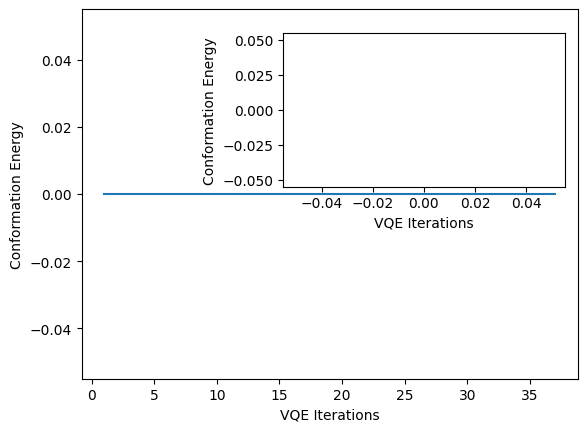

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformation Energy")
plt.xlabel("VQE Iterations")

fig.add_axes([0.44, 0.51, 0.44, 0.32])

plt.plot(counts[40:], values[40:])
plt.ylabel("Conformation Energy")
plt.xlabel("VQE Iterations")
plt.show()

In [24]:
result = protein_folding_problem.interpret(raw_result=raw_result)
print(
    "The bitstring representing the shape of the protein during optimization is: ",
    result.turn_sequence,
)
print("The expanded expression is:", result.get_result_binary_vector())

The bitstring representing the shape of the protein during optimization is:  001
The expanded expression is: 00_1____


In [25]:
print(
    f"The folded protein's main sequence of turns is: {result.protein_shape_decoder.main_turns}"
)
print(f"and the side turn sequences are: {result.protein_shape_decoder.side_turns}")

The folded protein's main sequence of turns is: [1, 0, 3, 0]
and the side turn sequences are: [None, None, None, None, None]


In [26]:
print(result.protein_shape_file_gen.get_xyz_data())

[['Y' '0.0' '0.0' '0.0']
 ['P' '0.5773502691896258' '0.5773502691896258' '-0.5773502691896258']
 ['Y' '1.1547005383792517' '0.0' '-1.1547005383792517']
 ['F' '1.7320508075688776' '-0.5773502691896258' '-0.5773502691896258']
 ['I' '2.3094010767585034' '-1.1547005383792517' '-1.1547005383792517']]


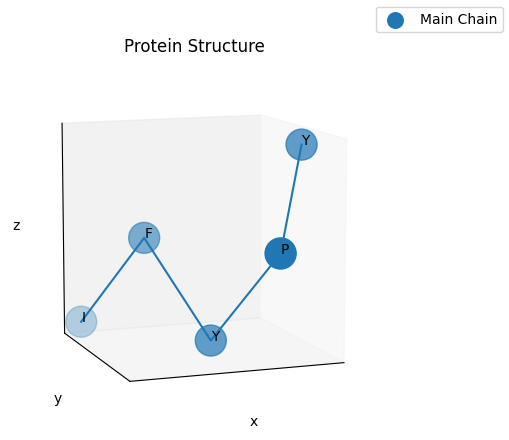

In [27]:
fig = result.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 70)

# IQPE Approach 


In [40]:
from qiskit import QuantumCircuit
from qiskit.algorithms import IterativePhaseEstimation

In [41]:
# ?IterativePhaseEstimation

In [42]:
# Sampler

In [43]:
num_iterations = 3
quantum_instance = None
qc = QuantumCircuit()
sampler = Sampler()
ipe = IterativePhaseEstimation(num_iterations, quantum_instance, sampler)

In [47]:
print(type(qubit_op))
qubit_op_matrix = qubit_op.to_matrix()
print(type(qubit_op_matrix))
print(qubit_op_matrix.shape)
# print(qubit_op_matrix)
print(type(ansatz))
print("ansatz num qubits:", ansatz.num_qubits)
print("ansatz num ancillas:", ansatz.num_ancillas)
print("ansatz num cl bits:", ansatz.num_clbits)

<class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>
<class 'numpy.ndarray'>
(64, 64)
<class 'qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes'>
ansatz num qubits: 6
ansatz num ancillas: 0
ansatz num cl bits: 6


In [51]:
qc_qubit_op = QuantumCircuit(6)
qc_qubit_op.unitary(qubit_op_matrix, [0,1,2,3,4,5])
print(type(qc_qubit_op))

ExtensionError: 'Input matrix is not unitary.'

In [48]:
result = ipe.estimate(qc_qubit_op, ansatz)
result

AttributeError: 'numpy.ndarray' object has no attribute 'num_qubits'

## VQE From Scratch Example 

U = [1  0  0  0  <br>
     0  0 -1  0  <br>
     0 -1  0  0  <br>
     0  0  0  1] <br>


Decompose U: <br>

U = 1/2*(I1I2 + Z1Z2) - 1/2*(X1X2 + Y1Y2) <br>

U * Ut = I, ==> U is unitary
     

In [1]:
from qiskit.opflow.primitive_ops import PauliSumOp
paulis  =  ['II', 'ZZ', 'XX', 'YY']
weights  =  [1/2, 1/2, -1/2, -1/2]
pauli_op = [([pauli,weight]) for pauli, weight in zip(paulis, weights)]
hamiltonian = PauliSumOp.from_list([ op for op in pauli_op ])

In [3]:
# Hamiltonian is a PauliSumOp
hamiltonian

PauliSumOp(SparsePauliOp(['II', 'ZZ', 'XX', 'YY'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j]), coeff=1.0)

In [57]:
# Return to the original matrix that we decomposed
op_matrix = hamiltonian.to_matrix()
print(op_matrix.shape)
print(op_matrix)

(4, 4)
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [59]:
qc = QuantumCircuit(2)
qc.unitary(op_matrix, [0,1])
print(type(qc))

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
